# Carga y análisis del dataset

Instalar librerías necesarias (si no están instaladas)

In [1]:
!pip install pandas openpyxl matplotlib seaborn --quiet
!pip install datasets --quiet
!pip install numpy==1.26.4 --quiet # (versión anterior)

# Después de ejecutar estos comandos es necesario reiniciar el kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


Importar librerías


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset
import torch

Carga del dataset y normalización

In [2]:
ruta = "/content/Dataset_Completo.xlsx"
df = pd.read_excel(ruta)

# Limpieza y normalización de la columna 'Category'
df['Category'] = df['Category'].astype(str).str.strip().str.lower()

# Mapeo de etiquetas: 'true' → 0 y 'fake' → 1
df['label'] = df['Category'].map({'true': 0, 'fake': 1})

# Verificación
print("Valores únicos en 'Category':", df['Category'].unique())
print("Valores únicos en 'label':", df['label'].unique())
print("\nDistribución de clases:")
print(df['label'].value_counts())

Valores únicos en 'Category': ['fake' 'true']
Valores únicos en 'label': [1 0]

Distribución de clases:
label
0    777
1    766
Name: count, dtype: int64


# Entrenamiento de BERT con el texto completo

In [3]:
from sklearn.model_selection import train_test_split

# 1. Usamos 'text', 'topic', 'source' y 'headline' como entrada. El campo LINK no lo utilizamos para el entrenamiento
df_texto = df[['Text', 'Topic', 'Source', 'Headline', 'label']].dropna().copy()

# Renombramos todas las columnas
df_texto.rename(columns={
    'Text': 'text',
    'Topic': 'topic',
    'Source': 'source',
    'Headline': 'headline'
}, inplace=True)

# 2. División del dataset en entrenamiento y prueba
train_df, test_df = train_test_split(df_texto, test_size=0.2, stratify=df_texto['label'], random_state=42)

# 3. Conversión a datasets de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 4. Tokenizador y tokenización
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# 5. Formateo
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 6. Modelo multilingüe
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

# 7. Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir="./results_multilingual",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",  # Para evaluar cada época
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=10,
    report_to="none"
)

# 8 Preparación metricas entrenamiento
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# 9. Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Espera 2 épocas sin mejorar
)

# 9. Entrenar el modelo
trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Map:   0%|          | 0/1234 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.556600,0.449987,0.796117
2,0.444900,0.512026,0.773463
3,0.273500,0.471875,0.809061


TrainOutput(global_step=234, training_loss=0.5157423651116526, metrics={'train_runtime': 564.824, 'train_samples_per_second': 21.848, 'train_steps_per_second': 1.381, 'total_flos': 974037126942720.0, 'train_loss': 0.5157423651116526, 'epoch': 3.0})

Guardar el modelo entrenado

In [4]:
# Guardar modelo y tokenizer tras el entrenamiento
trainer.save_model("./modelo_bert_multilingual")
tokenizer.save_pretrained("./modelo_bert_multilingual")

('./modelo_bert_multilingual/tokenizer_config.json',
 './modelo_bert_multilingual/special_tokens_map.json',
 './modelo_bert_multilingual/vocab.txt',
 './modelo_bert_multilingual/added_tokens.json')

# Evaluación del modelo con texto completo

Accuracy: 0.7961
Precision: 0.8409
Recall: 0.7255
F1-score: 0.7789

Reporte completo:
              precision    recall  f1-score   support

        True       0.76      0.87      0.81       156
        Fake       0.84      0.73      0.78       153

    accuracy                           0.80       309
   macro avg       0.80      0.80      0.79       309
weighted avg       0.80      0.80      0.80       309



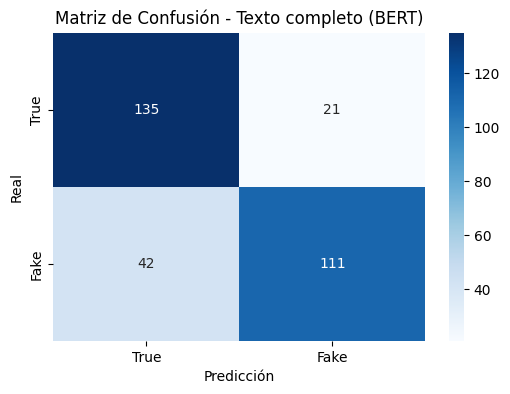

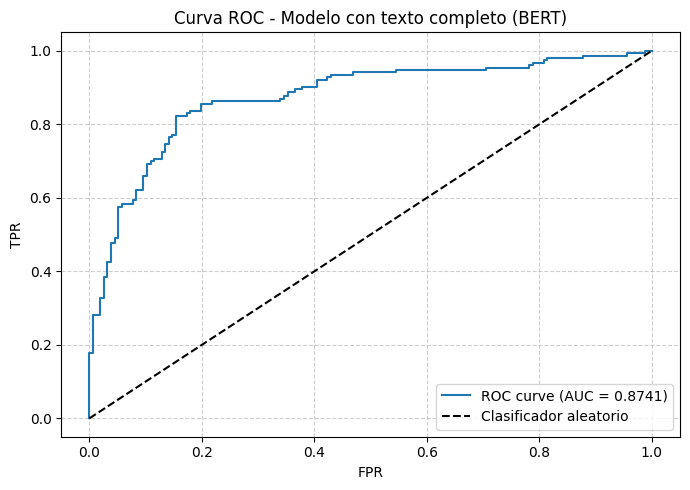

In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# 1. Obtener predicciones
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 2. Métricas principales
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 3. Reporte completo por clase
print("\nReporte completo:")
print(classification_report(labels, preds, target_names=["True", "Fake"]))

# 4. Matriz de confusión
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["True", "Fake"], yticklabels=["True", "Fake"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Texto completo (BERT)')
plt.show()

# 5. Curva ROC y AUC
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
auc = roc_auc_score(labels, probs)
fpr, tpr, _ = roc_curve(labels, probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Modelo con texto completo (BERT)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()